In [25]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torchaudio

import numpy as np
import pandas as pd
import librosa
import PIL
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import display, Markdown

import scripts.generate_dual_resonance as generation_script

In [2]:
import shared.utils as su

Failed to import torchvideotransforms. Proceeding without.
Please install using:
pip install git+https://github.com/hassony2/torch_videovision


In [3]:
sys.path.append(os.path.join(su.log.repo_path, "train"))
from network.autoencoder.autoencoder import AutoEncoder

### Load original samples

In [4]:
data_root = su.paths.get_data_root_from_hostname()
data_dir = os.path.join(
    data_root, "PouringLiquidsData",
)
meta_dir = os.path.join(os.path.dirname(su.log.repo_path), "PouringLiquidsData")

video_clip_dir = os.path.join(data_dir, "resized_clips")
audio_clip_dir = os.path.join(data_dir, "resized_clips_wav")
# First frame of the video to get a sense of the container
frame_dir = os.path.join(data_dir, "first_frames")
annot_dir = os.path.join(meta_dir, "annotations")

# Load side information: containers
container_path = os.path.join(
    meta_dir, "annotations/containers.yaml",
)
assert os.path.exists(container_path)
containers = su.io.load_yml(container_path)

# Load CSV
csv_path = os.path.join(annot_dir, f"localisation.csv")
df = pd.read_csv(csv_path)
print(" [:::] Shape of CSV (in original form): ", df.shape)

# Update CSV with container information (optional)
update_with_container_info = True
if update_with_container_info:
    rows = []
    for row in df.iterrows():
        row = row[1].to_dict()
        row.update(containers[row["container_id"]])
        rows.append(row)
    df = pd.DataFrame(rows)

# Update item_id
df["item_id"] = df.apply(
    lambda d: f"{d['video_id']}_{d['start_time']:.1f}_{d['end_time']:.1f}",
    axis=1,
)
# Update video clip path
df["video_clip_path"] = df["item_id"].apply(
    lambda d: os.path.join(
        video_clip_dir, f"{d}.mp4"
    )
)
df = df[df["video_clip_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available video: ", df.shape)
# Update audio clip path
df["audio_clip_path"] = df["item_id"].apply(
    lambda d: os.path.join(
        audio_clip_dir, f"{d}.wav"
    )
)
df = df[df["audio_clip_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available audio: ", df.shape)

# Update first frame path
df["first_frame_path"] = df["video_id"].apply(
    lambda d: os.path.join(
        frame_dir, f"{d}.png"
    )
)
df = df[df["first_frame_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available frames: ", df.shape)

df.shape

 [:::] Shape of CSV (in original form):  (806, 12)
 [:::] Shape of CSV with available video:  (806, 21)
 [:::] Shape of CSV with available audio:  (806, 22)
 [:::] Shape of CSV with available frames:  (806, 23)


(806, 23)

In [7]:
# Filter only train set rows
item_ids = pd.read_csv("../source_data/v0.4.20240518.csv").item_id.unique()
df = df[df.item_id.isin(item_ids)]
df.shape

(381, 23)

### Load Autoencoder model

In [9]:
def load_autoencoder_model(
        device,
        ckpt_dir = "/work/piyush/experiments/ddsp-pytorch/pld_80/checkpoints",
        ckpt_id = "200131.pth-100000",
    ):
    su.log.print_update("Loading model ", pos="left", color="green")

    # Load config
    config = os.path.join(su.log.repo_path, "configs/pld_80.yaml")
    config = OmegaConf.load(config)

    # Configure the config to use device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    config.device = device

    # Load model
    net = AutoEncoder(config)

    # Load trained checkpoint
    ckpt_path = os.path.join(ckpt_dir, ckpt_id)
    assert os.path.exists(ckpt_path), f"Checkpoints does not exist at {ckpt_path}"
    print(" [:::] Checkpoint path: ", ckpt_path)
    msg = net.load_state_dict(torch.load(ckpt_path))
    print(" [:::] Loaded checkpoint: ", msg)

    # Important: set in eval mode
    net.eval()

    # Move to device
    net = net.to(device)

    su.misc.num_params(net)

    return config, net

config, net = load_autoencoder_model(device)

Loading model ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::  
 [:::] Checkpoint path:  /work/piyush/experiments/ddsp-pytorch/pld_80/checkpoints/200131.pth-100000
 [:::] Loaded checkpoint:  <All keys matched successfully>
 [:::] Number of total parameters in AutoEncoder: 4.346M


In [12]:
nonlinear = False

In [38]:
# Define hyperparameters and constants
sr = 16000
stft = dict(n_fft=512, hop_length=256, n_mels=64)
margin = 8.

# Define ranges for different physical parameters
beta_range = [0.3, 0.7]
R_range = [1., 5.] # cm
H_range = [5., 25.] # cm
if not nonlinear:
    b_range = [0.01, 0.01] # determines l(t): b=0.01 implies l(t) is (appx) linear 
else:
    b_range = [-0.5, 0.5]

# Load container metadata
repo_path = su.log.repo_path
yaml_path = os.path.join(repo_path, "../PouringLiquidsData", "annotations/materials.yaml")
materials = su.io.load_yml(yaml_path)

# Load liquid metadata
yaml_path = os.path.join(repo_path, "../PouringLiquidsData", "annotations/liquids.yaml")
liquids = su.io.load_yml(yaml_path)

a_range = [0.0005, 0.005] # 1 - 5 mm thickness

alpha = 0.6

In [39]:
np.where(df.container_id == "container_1")

(array([ 0,  8,  9, 10, 11, 16, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
        75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),)

In [113]:
# Load audio from a real sample to condition the model for magnitude
i = 13
row = df.iloc[i].to_dict()
item_id = row["item_id"]
audio_path = row["audio_clip_path"]

# Get loudness from the real audio
y_real = generation_script.load_audio(audio_path, config.sample_rate)
with torch.no_grad():
    loudness = net.encoder.loudness_extractor(
        {"audio": y_real.to(device)},
    )
num_frames = loudness.shape[1]

### Cylinder

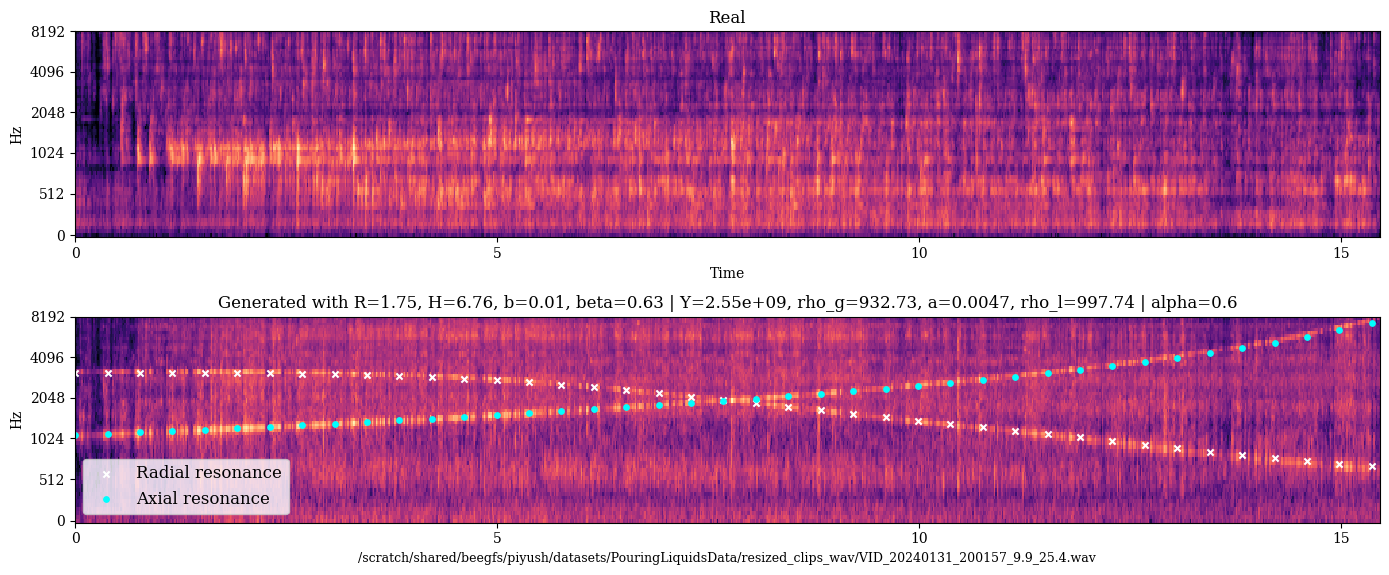

In [120]:
T = y_real.shape[1] / config.sample_rate
b = np.random.uniform(*b_range)
beta = np.random.uniform(*beta_range)
H = np.random.uniform(*H_range)
R = np.random.uniform(*R_range)

# Thickness of container
a = np.random.uniform(*a_range)

# Sample a material
material = np.random.choice(list(materials.keys()))
material_info = materials[material]

x = material_info["youngs_modulus_range"]
x = [eval(y) for y in x]
Y = np.random.uniform(*x)

x = material_info["density_range"]
# x = [eval(y) for y in x]
rho_g = np.random.uniform(*x)

# Sample a liquid
liquid = np.random.choice(list(liquids.keys()))

x = liquids[liquid]["density_range"]
# x = [eval(y) for y in x]
rho_l = np.random.uniform(*x)

# container_material = np.random.choice(container_materials)
# Y = np.random.uniform(*Y_range[container_material])
# rho_g = np.random.uniform(*rho_g_range[container_material])
# liquid_temperature = np.random.choice(liquid_temperatures)
# rho_l = np.random.uniform(*rho_l_range[liquid_temperature])

# Sample timestamps uniformly
timestamps = np.linspace(0., T, num_frames, endpoint=True)

# Compute length of air column
lengths = generation_script.compute_length_of_air_column_cylinder(timestamps, T, H, b)

# Compute axial frequencies
frequencies_axial = generation_script.compute_frequencies_axial_cylinder(
    lengths=lengths, radius=R, beta=beta,
)

# Compute radial frequencies
heights = H - lengths
frequencies_radial = generation_script.compute_radial_frequency_cylinder(
    heights=heights/100., R=R/100., H=H/100., Y=Y, rho_g=rho_g, a=a, rho_l=rho_l,
)

# Generate audio with radial frequencies
y_gene_radial = generation_script.generate_audio(net, loudness, frequencies_radial)

# Generate audio with axial frequencies
y_gene_axial = generation_script.generate_audio(net, loudness, frequencies_axial)

# Mix the two with a weight factor
y_gene = alpha * y_gene_axial + (1 - alpha) * y_gene_radial

# Save sample to visualise
radial_suffix = f"Y={Y:.2e}, rho_g={rho_g:.2f}, a={a:.4f}, rho_l={rho_l:.2f}"
axial_suffix = f"R={R:.2f}, H={H:.2f}, b={b:.2f}, beta={beta:.2f}"
FMAX = sr // 2
# Find indices where both frequencies < FMAX
indices = np.where((frequencies_radial < FMAX) & (frequencies_axial < FMAX))[0]
generation_script.show_real_and_generated_audio(
    y_true=y_real.numpy()[0],
    y_gen=y_gene.numpy()[0],
    sr=sr,
    show=True,
    T=timestamps[indices],
    F0_radial=frequencies_radial[indices],
    # F0_radial=None,
    F0_axial=frequencies_axial[indices],
    # F0_axial=None,
    suffix=f"{axial_suffix} | {radial_suffix} | alpha={alpha}",
    xlabel=audio_path,
    n_show=40,
)
torchaudio.save(f"./audio.wav", y_gene, sr)

In [121]:
y_real.shape, y_gene.shape

(torch.Size([1, 247467]), torch.Size([1, 247424]))

In [122]:
def librosa_harmonic_spectrogram_db(y, n_fft=512, hop_length=256, margin=16., n_mels=None):
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    if len(y.shape) == 2:
        y = y.mean(axis=0)
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, center=True)
    DH, DP = librosa.decompose.hpss(D, margin=margin)
    amplitude_h = np.sqrt(2) * np.abs(DH)
    if n_mels is None:
        # Usual dB spectrogram
        SH = librosa.amplitude_to_db(amplitude_h, ref=np.max)
    else:
        # Mel-scaled dB spectrogram
        S = librosa.amplitude_to_db(amplitude_h)
        SH = librosa.feature.melspectrogram(S=S, n_mels=n_mels)
    return SH


def show_logmelspectrogram(S, sr, n_fft=512, hop_length=256, figsize=(10, 3), ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    librosa.display.specshow(
        S,
        sr=sr,
        hop_length=hop_length,
        n_fft=n_fft,
        y_axis='mel',
        x_axis='time',
        ax=ax,
    )
    ax.set_title("LogMelSpectrogram")
    if show:
        plt.show()

In [123]:
spec_real = librosa_harmonic_spectrogram_db(
    y_real, n_mels=64,
)
# show_logmelspectrogram(spec_real, sr=48000)

spec_gene = librosa_harmonic_spectrogram_db(
    y_gene, n_mels=64,
)
# show_logmelspectrogram(spec_gene, sr=48000)

In [124]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"


# Define a function to increase font sizes for a specific plot
def increase_font_sizes(ax, font_scale=1.6):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize() * font_scale)


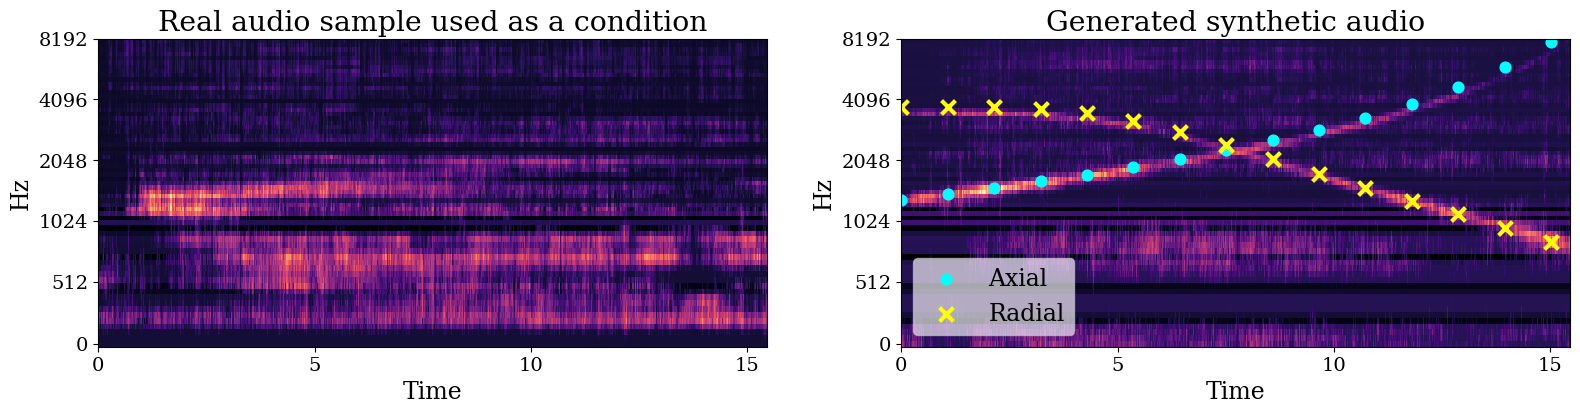

In [131]:
font_scale = 1.7

fig, axes = plt.subplots(1, 2, figsize=(19, 4))
ax = axes[0]
show_logmelspectrogram(spec_real, sr=sr, ax=ax, show=False)
ax.set_title("Real audio sample used as a condition")
increase_font_sizes(ax, font_scale)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)


ax = axes[1]
show_logmelspectrogram(spec_gene, sr=sr, ax=ax, show=False)
ax.set_title("Generated synthetic audio")
increase_font_sizes(ax, font_scale)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

FMAX = 8000 / 1.2
indices = np.where((frequencies_radial < FMAX) & (frequencies_axial < FMAX))[0]
T = timestamps[indices]
F0_radial = frequencies_radial[indices]
F0_axial = frequencies_axial[indices]
n_show = 14
n = len(T)
skip = n // n_show
ax.scatter(
    T[::skip], 1.2 * F0_axial[::skip], color="cyan", s=60, label="Axial",
)
ax.scatter(
    T[::skip], 1.2 * F0_radial[::skip], color="yellow", s=100, marker="x", linewidths=3, label="Radial",
)
ax.legend(fontsize=17, framealpha=0.65)

# plt.tight_layout()
plt.savefig("./sample_synthetic-v2.pdf", bbox_inches="tight")
plt.show()

### Semi-cone

### Bottleneck

$$
f(t) = \frac{c}{2\pi} \frac{R_{n}}{R_{b}}.\sqrt{\frac{1}{H_{n} + \beta R_{n}}}.\sqrt{\frac{1}{l(t)}}
$$
where $\beta = 0.6 + 8 / \pi$

In [134]:
def compute_axial_frequency_bottleneck(lengths, Rb, Hb, Rn, Hn, beta=(0.6 + 8/np.pi), c=340*100):
    eps = 1e-6
    kappa = (0.5 * c / np.pi) * (Rn/Rb) * np.sqrt(1 / (Hn + beta * Rn))
    frequencies = kappa * np.sqrt(1 / (lengths + eps))
    return frequencies

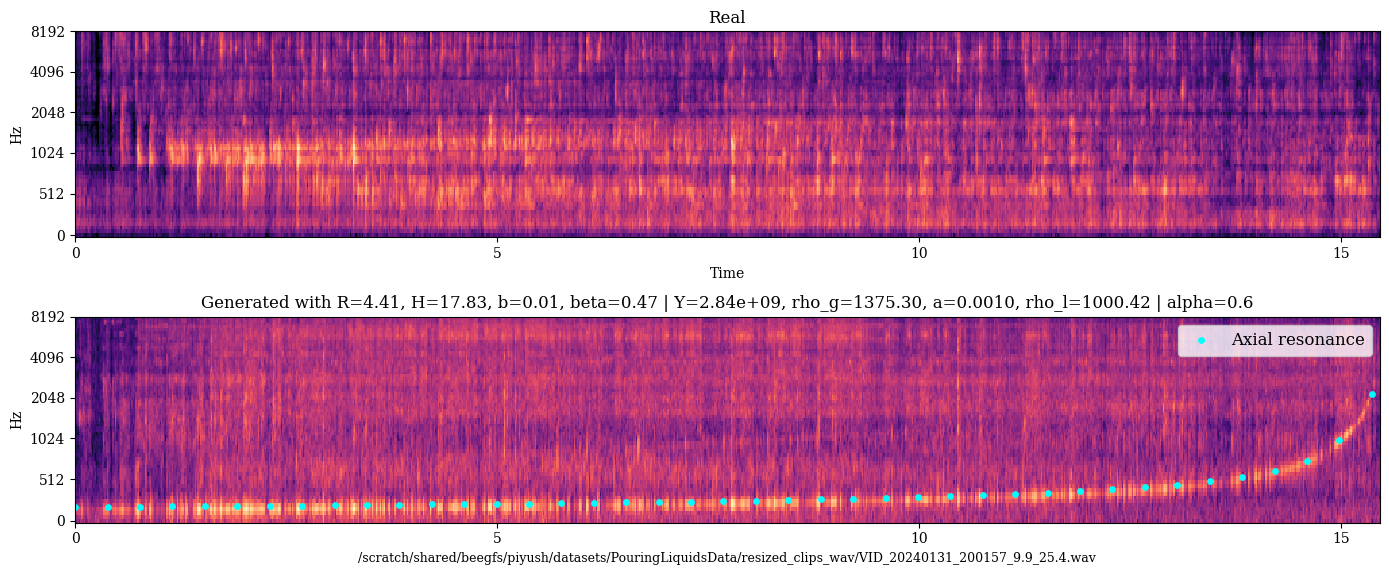

In [140]:
T = y_real.shape[1] / config.sample_rate
b = np.random.uniform(*b_range)
beta = np.random.uniform(*beta_range)
H = np.random.uniform(*H_range)
R = np.random.uniform(*R_range)

Hn_range = [0.5, 3.5]
Hn = np.random.uniform(*Hn_range)
Rn_range = [0.5, 3.5]
Rn = np.random.uniform(*Rn_range)

# Thickness of container
a = np.random.uniform(*a_range)

# Sample a material
material = np.random.choice(list(materials.keys()))
material_info = materials[material]

x = material_info["youngs_modulus_range"]
x = [eval(y) for y in x]
Y = np.random.uniform(*x)

x = material_info["density_range"]
# x = [eval(y) for y in x]
rho_g = np.random.uniform(*x)

# Sample a liquid
liquid = np.random.choice(list(liquids.keys()))

x = liquids[liquid]["density_range"]
# x = [eval(y) for y in x]
rho_l = np.random.uniform(*x)

# container_material = np.random.choice(container_materials)
# Y = np.random.uniform(*Y_range[container_material])
# rho_g = np.random.uniform(*rho_g_range[container_material])
# liquid_temperature = np.random.choice(liquid_temperatures)
# rho_l = np.random.uniform(*rho_l_range[liquid_temperature])

# Sample timestamps uniformly
timestamps = np.linspace(0., T, num_frames, endpoint=True)

# Compute length of air column
lengths = generation_script.compute_length_of_air_column_cylinder(timestamps, T, H, b)

# Compute axial frequencies
# NOTE: approximates H, R as a cylinder to compute lengths
frequencies_axial = compute_axial_frequency_bottleneck(
    lengths=lengths, Rb=R, Hb=H, Rn=Rn, Hn=Hn,
)

# Generate audio with axial frequencies
y_gene_axial = generation_script.generate_audio(net, loudness, frequencies_axial)

# plt.plot(timestamps, lengths)
# plt.plot(timestamps, np.clip(frequencies_axial, 0, 8000))

# Save sample to visualise
radial_suffix = f"Y={Y:.2e}, rho_g={rho_g:.2f}, a={a:.4f}, rho_l={rho_l:.2f}"
axial_suffix = f"R={R:.2f}, H={H:.2f}, b={b:.2f}, beta={beta:.2f}"
FMAX = sr // 2
# Find indices where both frequencies < FMAX
indices = np.where((frequencies_radial < FMAX) & (frequencies_axial < FMAX))[0]
generation_script.show_real_and_generated_audio(
    y_true=y_real.numpy()[0],
    y_gen=y_gene_axial.numpy()[0],
    sr=sr,
    show=True,
    T=timestamps[indices],
    # F0_radial=frequencies_radial[indices],
    F0_radial=None,
    F0_axial=frequencies_axial[indices],
    # F0_axial=None,
    suffix=f"{axial_suffix} | {radial_suffix} | alpha={alpha}",
    xlabel=audio_path,
    n_show=40,
)
torchaudio.save(f"./audio.wav", y_gene, sr)

In [142]:
spec_gene = librosa_harmonic_spectrogram_db(
    y_gene_axial, n_mels=64,
)

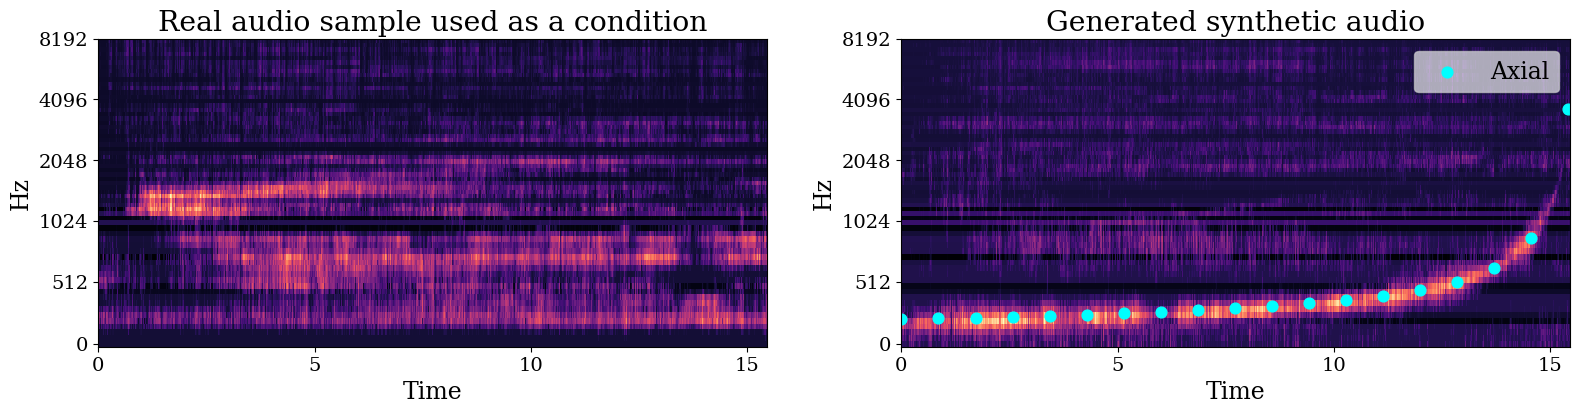

In [144]:
font_scale = 1.7

fig, axes = plt.subplots(1, 2, figsize=(19, 4))
ax = axes[0]
show_logmelspectrogram(spec_real, sr=sr, ax=ax, show=False)
ax.set_title("Real audio sample used as a condition")
increase_font_sizes(ax, font_scale)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)


ax = axes[1]
show_logmelspectrogram(spec_gene, sr=sr, ax=ax, show=False)
ax.set_title("Generated synthetic audio")
increase_font_sizes(ax, font_scale)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

FMAX = 8000 / 1.2
indices = np.where((frequencies_radial < FMAX) & (frequencies_axial < FMAX))[0]
T = timestamps[indices]
# F0_radial = frequencies_radial[indices]
F0_axial = frequencies_axial[indices]
n_show = 18
n = len(T)
skip = n // n_show
ax.scatter(
    T[::skip], 1.2 * F0_axial[::skip], color="cyan", s=60, label="Axial",
)
# ax.scatter(
#     T[::skip], 1.2 * F0_radial[::skip], color="yellow", s=100, marker="x", linewidths=3, label="Radial",
# )
ax.legend(fontsize=17, framealpha=0.65)

# plt.tight_layout()
plt.savefig("./sample_synthetic_bottleneck-v1.pdf", bbox_inches="tight")
plt.show()